<h3>Table of Content</h3>
<p>1. Imports</p>
<p>2. Data Exploration and Preparation</p>
<ul style="list-style-type:none">
    <li>2.1  Variable Identification</li>
    <li>2.2  Univariate Analysis</li>
    <li>2.3  Bi-variate Analysis</li>
    <li>2.4  Missing values treatment</li>
    <li>2.5  Feature Engineering (Variable transformation and creation)</li>
</ul>
<p>3. Test Data Preparation</p>
<p>4. Modeling</p>
<ul style="list-style-type:none">
    <li>4.1  Baseline (Overall Avg Item Sales)</li>
    <li>4.2  Avg Item Sales by Item Identifier</li>
    <li>4.3  Avg Item Sales by Outlet Identifier</li>
    <li>4.4  Linear Regression</li>
    <li>4.5  Ridge Linear Regression</li>
    <li>4.6  Decission Tree</li>
    <li>4.7  top features decision Tree</li>
    <li>4.8  Random Forest</li>
</ul>

In [1]:
# imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('Train_UWu5bXk.csv')
test = pd.read_csv('Test_u94Q5KV.csv')

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 1.1 Variable Identification
<p><b>Target Variable</b>: Item_Outlet_Sales</p>
<p>5 numerical and 5 categorical and 2 identifiers (continous variables)</p>

In [4]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Here We can find some missing values in Item_Weight. Outlet_Establishment_Year can be converted to years old from current year for better model building. We can do these changes along with filling missing values in preprocessing step

### 1.2. Univariate Analysis
<p>1. boxplots for numeric columns (5)</p>
<p>2. barplots for categorical columns (5)</p>
<p>Rest is text field containing item identification number</p>

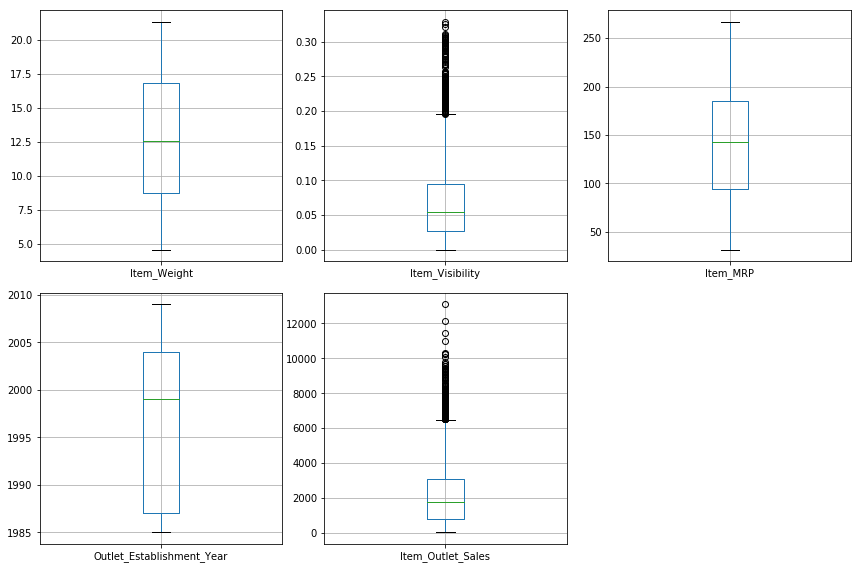

In [5]:
# numeric_columns = list(train.describe().columns.values)
numeric_columns = train.select_dtypes(include=[np.number]).columns.tolist()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.delaxes(axes.flatten()[-1])
fig.tight_layout()
for i in range(5):
    train.boxplot(column=numeric_columns[i], ax=axes.flatten()[i])

Though few data points in Item_Visibility and ITem_Outlet_Sales are outliers according to boxplots, these are continous points from upper extremes and are important in the data. So, we are not removing or imputing these data points.

In [6]:
non_numeric_columns = train.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_columns = list(set(non_numeric_columns) - set(['Item_Identifier']))
categorical_columns

['Outlet_Identifier',
 'Outlet_Location_Type',
 'Item_Fat_Content',
 'Outlet_Type',
 'Item_Type',
 'Outlet_Size']

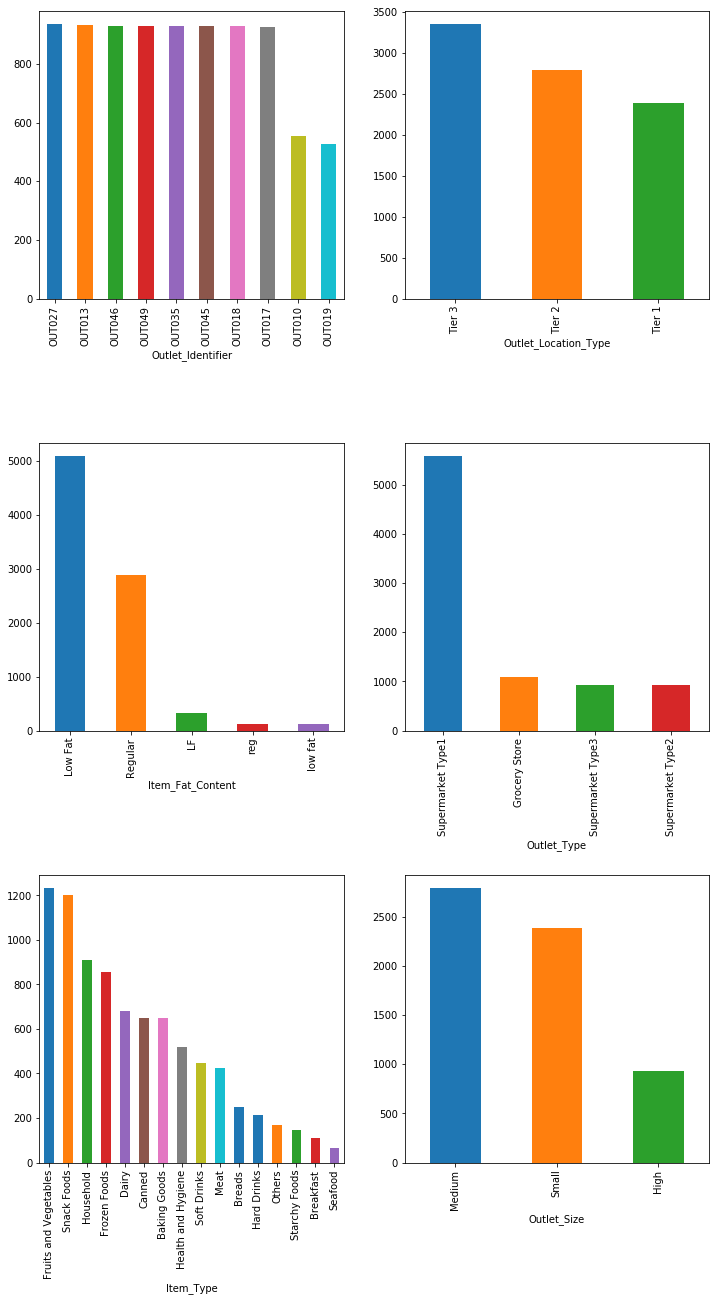

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
for i in range(len(categorical_columns)):
    plt.subplots_adjust(left=None, bottom=0, right=None, top=2, wspace=None, hspace=0.5)
    ax.flatten()[i].set_xlabel(categorical_columns[i])
    train[categorical_columns[i]].value_counts().plot.bar(ax=ax.flatten()[i])

Item_Fat_Content has low fat in 3 versions and regular in 2 versions. We need to combine them before feding the data to model building.

### 1.3 Bivariate Analysis

Continous vs Continous Variables
<p>Heatmap using correlation matrix</p>

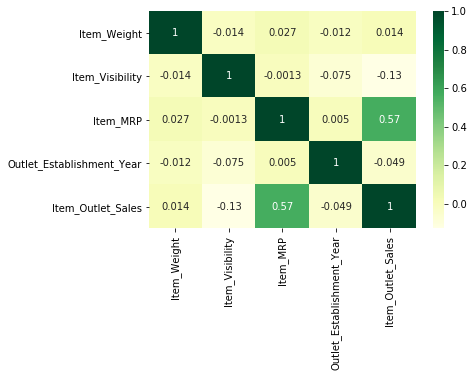

In [8]:
train.corr()
sns.heatmap(train.corr(), annot=True, cmap='YlGn')

A strong correlation between Item_MRP and Item_Outlet_Sales

### 1.4 Missing value detection and treatment

In [9]:
# get total and percent of missing values for each feature
total_missing = train.isnull().sum().sort_values(ascending=False)
percent_missing = (train.isnull().sum() * 100/train.isnull().count()).sort_values(ascending=False)

pd.concat([total_missing, percent_missing], axis=1, keys=['total', 'percent'])

,total,percent
Outlet_Size,2410,28.276428
Item_Weight,1463,17.165317
Item_Outlet_Sales,0,0.000000
Outlet_Type,0,0.000000
Outlet_Location_Type,0,0.000000
Outlet_Establishment_Year,0,0.000000
Outlet_Identifier,0,0.000000
Item_MRP,0,0.000000
Item_Type,0,0.000000
Item_Visibility,0,0.000000


#### Item Weight
for Item_Weight we can use the average weight using the Item_Identifier. It the Item_Identifier doesn't exist anywhere else or has another null Item_weight we will fill average weight taken over all the Item_weights.

In [10]:
# creating a table containing average Item_Weight for each Item_Identifier
Item_Avg_Weight = train.pivot_table(index='Item_Identifier', values='Item_Weight')

missing_Item_Weight = train['Item_Weight'].isnull()

train.loc[missing_Item_Weight, 'Item_Weight'] = train.loc[missing_Item_Weight, 'Item_Identifier'].apply(lambda x: Item_Avg_Weight.loc[x])

train['Item_Weight'] = train['Item_Weight'].fillna(train['Item_Weight'].mean())

#### Outlet Size

In [11]:
train[train['Outlet_Identifier'].isin(train[train['Outlet_Size'].isnull()]['Outlet_Identifier'].unique().tolist())]['Outlet_Size'].notnull().sum()

0

<p>One way to fill is to check if a given Outlet_Identifier containing null value has non-null value in any other row. But as found above, all Outlet_Identifiers containing null Outlet_Size have no non-null values to fill. </p>
<p>Other way to fill the missing Outlet_Size values is to take mode of Outlet_Size for the missing data's Outlet_type since Outlet_Size is in a way dependent on the type of the Outlet (Supermarket / Grocery etc)</p>

In [12]:
missing_Outlet_Size = train['Outlet_Size'].isnull()

print('Mode for each Outlet')
Outlet_Type_Mode = train[['Outlet_Type', 'Outlet_Size']].dropna().groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.value_counts().index[0])
Outlet_Type_Mode

Mode for each Outlet


Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

In [13]:
train.loc[missing_Outlet_Size, 'Outlet_Type'].value_counts()

Supermarket Type1    1855
Grocery Store         555
Name: Outlet_Type, dtype: int64

In [14]:
train.loc[missing_Outlet_Size, 'Outlet_Size'] = train.loc[missing_Outlet_Size, 'Outlet_Type'].apply(lambda x: Outlet_Type_Mode[x])

In [15]:
print('No of missing values in the dataset after Treatment are : {}'.format(train.isnull().sum().sum()))
# train.isnull().sum().sum()

No of missing values in the dataset after Treatment are : 0


### 1.5 Feature Engineering

In [16]:
#Years: data collected in 2013
train['Outlet_Years_old'] = 2013 - train['Outlet_Establishment_Year']

In [17]:
# Fix inconsistencies in Item_Fat_Content:
print('Original Categories:')
print(train['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(train['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


In [18]:
#One Hot Coding:
train = pd.get_dummies(train, columns=['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Size','Outlet_Type'])

In [19]:
# Outlet_Establishment_Year can be removed as we found it's replacement in Outlet_Years_Old
train.drop(['Outlet_Establishment_Year'], axis=1, inplace=True)

In [20]:
train.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Outlet_Years_old,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,9.30,0.016047,249.8092,OUT049,3735.1380,14,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,443.4228,4,0,1,0,...,0,0,1,0,1,0,0,0,1,0
2,FDN15,17.50,0.016760,141.6180,OUT049,2097.2700,14,1,0,0,...,1,0,0,0,1,0,0,1,0,0
3,FDX07,19.20,0.000000,182.0950,OUT010,732.3800,15,0,1,0,...,0,0,1,0,0,1,1,0,0,0
4,NCD19,8.93,0.000000,53.8614,OUT013,994.7052,26,1,0,0,...,0,0,1,1,0,0,0,1,0,0


Now that the whole data is numeric (leaving Identifiers aside), we can fit the data to model and apply Machine learning techniques to find out the model accuracy and target variable predictions.

### 3. Clean the test data in similar way as we did for train data

In [21]:
# missing value detection
test_total_missing = test.isnull().sum().sort_values(ascending=False)
test_percent_missing = ((test_total_missing/test.isnull().count())*100).sort_values(ascending=False)
pd.concat([test_percent_missing, test_percent_missing], axis=1, keys=['total missing', 'percent missing'])

,total missing,percent missing
Outlet_Size,28.269671,28.269671
Item_Weight,17.180074,17.180074
Outlet_Type,0.000000,0.000000
Outlet_Location_Type,0.000000,0.000000
Outlet_Identifier,0.000000,0.000000
Outlet_Establishment_Year,0.000000,0.000000
Item_Visibility,0.000000,0.000000
Item_Type,0.000000,0.000000
Item_MRP,0.000000,0.000000
Item_Identifier,0.000000,0.000000


In [22]:
# check descriptive stats for test dataset
a = test['Item_Weight'].describe()

### fill Item_Weight and Outlet_Size in similar way as we did for train dataset

## for Item_Weight, fill average value of particular Item Identifier and if it doesn't exist, a universal average on all Items
# missing Item_Weight rows
test_missing_Item_Weight_Index = test['Item_Weight'].isnull()
# create test table cotaining Item_Identifier average weight
test_Avg_Item_Weight = pd.pivot_table(test, values='Item_Weight', index='Item_Identifier')

# fill these weights in test data according to Identifiers
test.loc[test_missing_Item_Weight_Index, 'Item_Weight'] = test.loc[test_missing_Item_Weight_Index, 'Item_Identifier'].apply(lambda x: test_Avg_Item_Weight.loc[x])
b = test['Item_Weight'].describe()

# fill the remaining items with avg item_weights
test['Item_Weight'].fillna(value=test['Item_Weight'].mean(), inplace=True)

print(pd.concat([a, b, test['Item_Weight'].describe()], keys=['Item_Weight_before', 'Item_Weight_Id_mean', 'Item_Weight_mean'], axis=1))

       Item_Weight_before  Item_Weight_Id_mean  Item_Weight_mean
count         4705.000000          5661.000000       5681.000000
mean            12.695633            12.675976         12.675976
std              4.664849             4.657559          4.649352
min              4.555000             4.555000          4.555000
25%              8.645000             8.630000          8.630000
50%             12.500000            12.350000         12.350000
75%             16.700000            16.700000         16.700000
max             21.350000            21.350000         21.350000


In [23]:
## fill Outlet_Size missing values. Based on mode of Outlet_Type

# create table of outlet size modes for each outlet types
test_outlet_size_mode = test[['Outlet_Type', 'Outlet_Size']].groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.value_counts().index[0])
test_missing_outlet_size_index = test['Outlet_Size'].isnull()

test.loc[test_missing_outlet_size_index, 'Outlet_Size'] = test.loc[test_missing_outlet_size_index, 'Outlet_Type'].apply(lambda x: test_outlet_size_mode.loc[x])

In [24]:
#Years: data collected in 2013
test['Outlet_Years_old'] = 2013 - test['Outlet_Establishment_Year']

# Fix inconsistencies in Item_Fat_Content:
print('Original Categories:')
print(test['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(test['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    3668
Regular    2013
Name: Item_Fat_Content, dtype: int64


In [25]:
# Outlet_Establishment_Year can be removed as we found it's replacement in Outlet_Years_Old
test.drop(['Outlet_Establishment_Year'], axis=1, inplace=True)

#One Hot Coding:
test = pd.get_dummies(test, columns=['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Size','Outlet_Type'])

In [26]:
print('No of null values are {}'.format(test.isnull().sum().sum()))

No of null values are 0


In [27]:
test.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Years_old,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDW58,20.750,0.007565,107.8622,OUT049,14,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,FDW14,8.300,0.038428,87.3198,OUT017,6,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
2,NCN55,14.600,0.099575,241.7538,OUT010,15,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,FDQ58,7.315,0.015388,155.0340,OUT017,6,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,FDY38,13.600,0.118599,234.2300,OUT027,28,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1


### 4. Modelling

In [28]:
# Baseline modelling
# predicting mean of Item_Outlet_Sales for all items.
mean_Item_Outlet_Sales = train['Item_Outlet_Sales'].mean()

basemodel = test[['Item_Identifier', 'Outlet_Identifier']]
basemodel['Item_Outlet_Sales'] = mean_Item_Outlet_Sales

# basemodel.to_csv("basemodel.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
# Average sales by product
avg_item_outlet_sales_df = pd.pivot_table(train[['Item_Identifier', 'Item_Outlet_Sales']], index='Item_Identifier', values='Item_Outlet_Sales')

avg_item_outlet_sales_model = test[['Item_Identifier', 'Outlet_Identifier']]
avg_item_outlet_sales_model['Item_Outlet_Sales'] = avg_item_outlet_sales_model['Item_Identifier'].apply(lambda x: avg_item_outlet_sales_df.loc[x])

# avg_item_outlet_sales_model.to_csv("avg_item_outlet_sales.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [30]:
# Average sales by outlet
avg_outlet_sales_df = pd.pivot_table(train[['Outlet_Identifier', 'Item_Outlet_Sales']], index='Outlet_Identifier', values='Item_Outlet_Sales')

avg_outlet_sales_model = test[['Item_Identifier', 'Outlet_Identifier']]
avg_outlet_sales_model['Item_Outlet_Sales'] = avg_outlet_sales_model['Outlet_Identifier'].apply(lambda x: avg_outlet_sales_df.loc[x])

# avg_outlet_sales_model.to_csv("avg_item_outlet_sales.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [31]:
# function to build, fit and test it's performance on train data

#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\sit


Model Report
RMSE : 1128
CV Score : Mean - 1131 | Std - 42.58 | Min - 1079 | Max - 1213


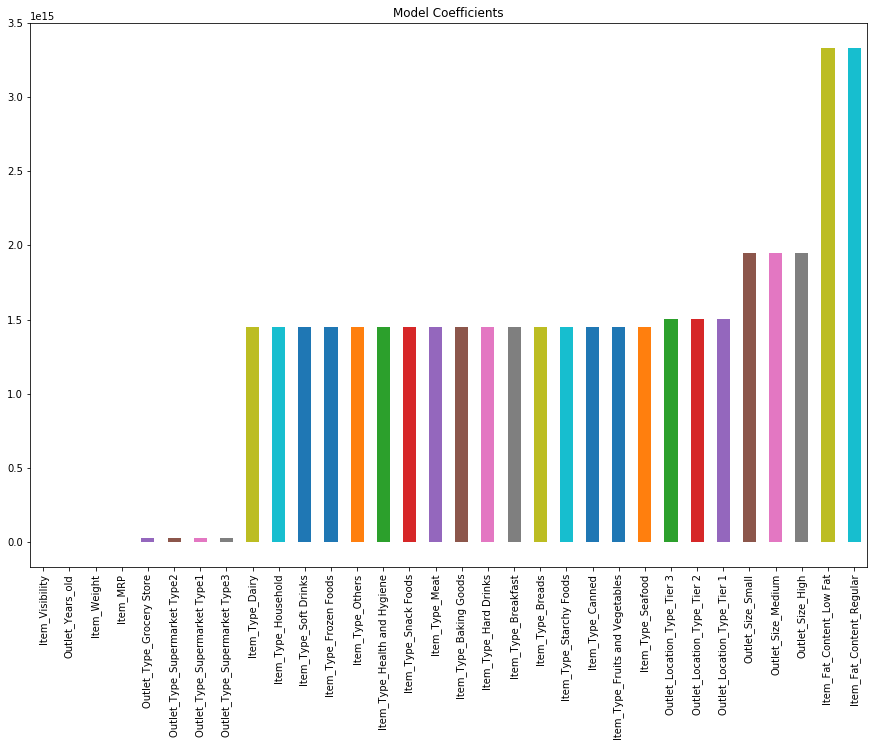

In [32]:
# Linear Regression Model

from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients', figsize=(15, 10))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\sit


Model Report
RMSE : 1130
CV Score : Mean - 1133 | Std - 42.92 | Min - 1080 | Max - 1218


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


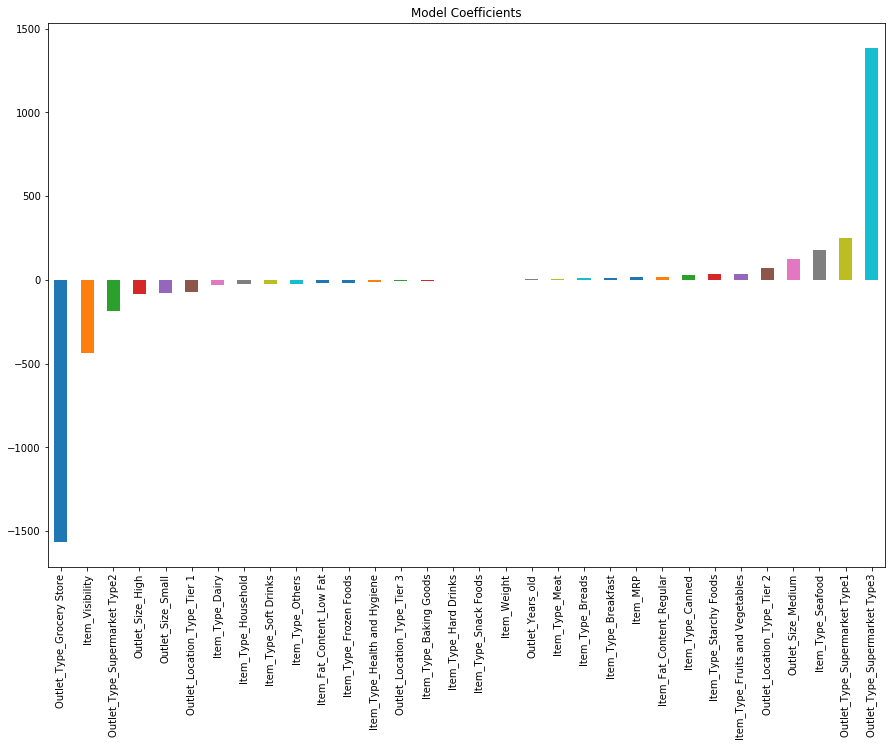

In [33]:
# Ridge Regression Model:
# since the model coefficients are too high

predictors = [x for x in train.columns if x not in [target]+IDcol]
ridge = Ridge(alpha=0.05,normalize=True)
modelfit(ridge, train, test, predictors, target, IDcol, 'Ridge_regression_model.csv')
coef2 = pd.Series(ridge.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients', figsize=(15, 10))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\sit


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.39 | Min - 1010 | Max - 1183


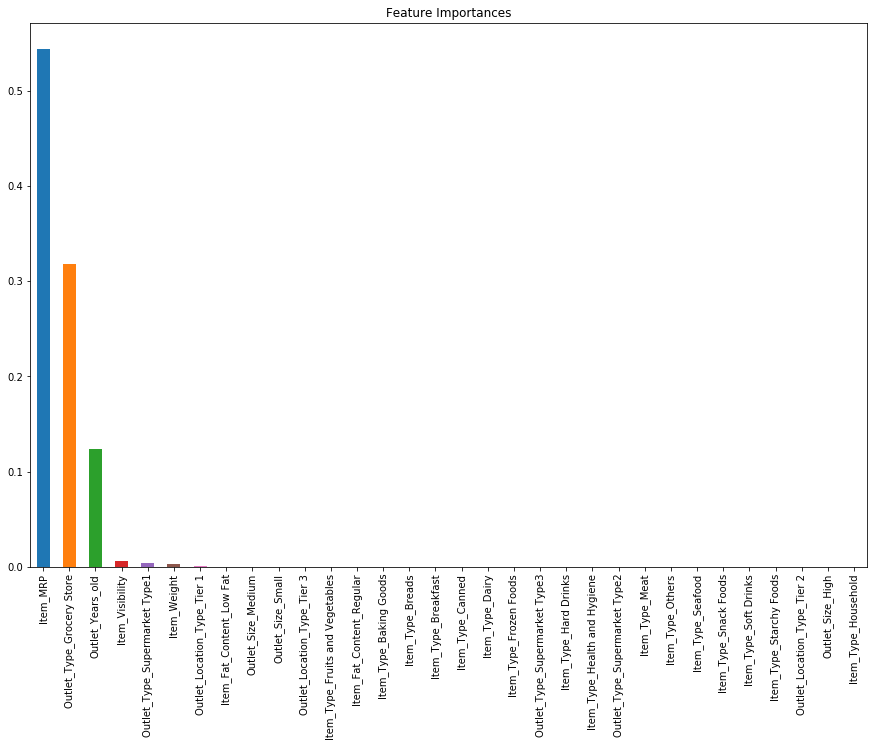

In [34]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
decision_tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(decision_tree, train, test, predictors, target, IDcol, 'decision_tree.csv')
coef3 = pd.Series(decision_tree.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances', figsize=(15, 10))

RMSE is less than cv here. This might be due to overfitting. lets take just the first 4 features for building the model as the rest are least important compared to these

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\sit


Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


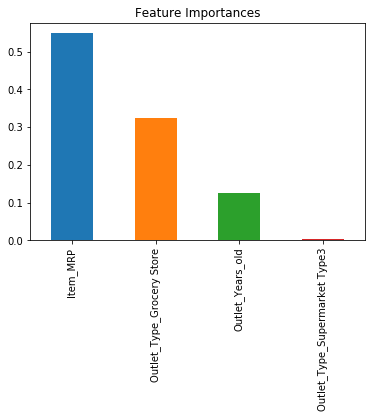

In [35]:
# decision tree with top 4 features
predictors = ['Item_MRP','Outlet_Type_Grocery Store','Outlet_Type_Supermarket Type3','Outlet_Years_old']
decision_tree_top4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(decision_tree_top4, train, test, predictors, target, IDcol, 'decision_tree_top4.csv')
coef4 = pd.Series(decision_tree_top4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

<b>Item_MRP, Outlet_Type_Grocery Store, Outlet_Type_Supermarket Type3, Outlet_Years_old</b> are the 4 most importsnt features determining the Item_Outlet_Sales and the RMSE error is close to 1150. Decision Tree with top 4 features is giving us the maximum accuracy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\sit


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.61 | Min - 1021 | Max - 1161


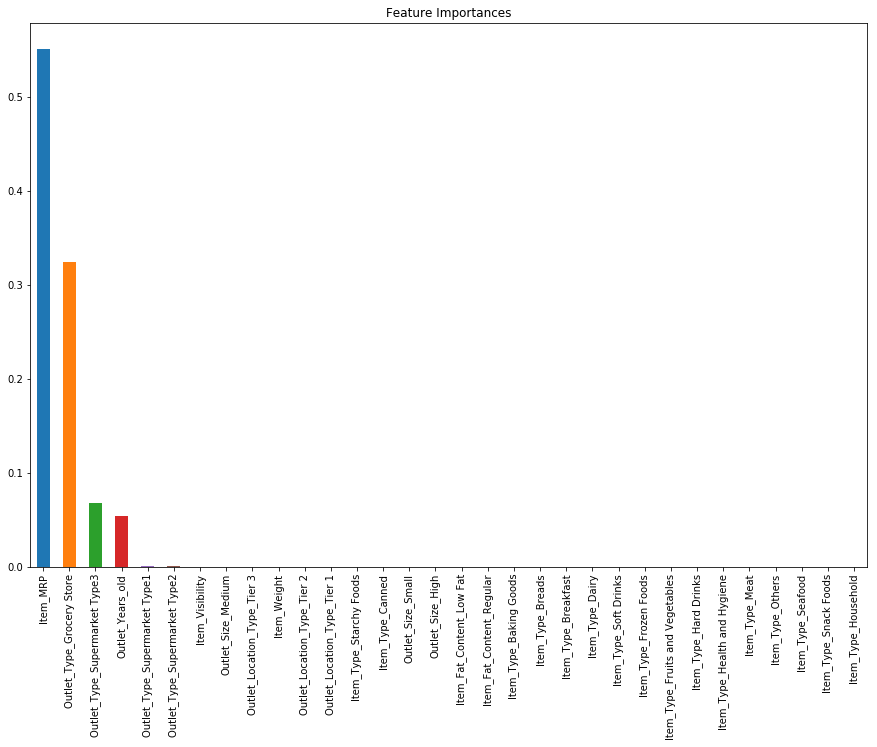

In [36]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
random_forest = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(random_forest, train, test, predictors, target, IDcol, 'random_forest.csv')
coef5 = pd.Series(random_forest.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances', figsize=(15, 10))